# Water Potability Prediction using Class Weight Balancing
This notebook compares SVM and RandomForest classifiers using the `class_weight='balanced'` parameter to handle class imbalance.

### Step 1: Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
# Load the dataset
df = pd.read_csv('water_data.csv')
df.head()

,ServerTimeStamp,OriginalTimeStamp,apiKey,Suhu,TDS,Salinitas,pH,Turbiditas
0,31/05/2025 07:37:11,2025-05-31 7:37:08,AKfycbzI-Z8_x_y7IX-iUJd3nko3GGvT0KR8PKD-YWbbiZ...,26.25,14.81,30.82,6.57,3.79
1,31/05/2025 07:37:15,2025-05-31 7:37:08,AKfycbzI-Z8_x_y7IX-iUJd3nko3GGvT0KR8PKD-YWbbiZ...,26.31,14.99,32.15,6.57,3.57
2,31/05/2025 07:37:19,2025-05-31 7:37:08,AKfycbzI-Z8_x_y7IX-iUJd3nko3GGvT0KR8PKD-YWbbiZ...,26.31,14.87,32.04,6.58,3.77
3,31/05/2025 07:37:24,2025-05-31 7:37:08,AKfycbzI-Z8_x_y7IX-iUJd3nko3GGvT0KR8PKD-YWbbiZ...,26.37,14.86,31.98,6.57,3.70
4,31/05/2025 07:37:27,2025-05-31 7:37:08,AKfycbzI-Z8_x_y7IX-iUJd3nko3GGvT0KR8PKD-YWbbiZ...,26.37,14.81,31.81,6.58,3.81


In [3]:
dropTS=['ServerTimeStamp','OriginalTimeStamp','apiKey']
df.drop(dropTS, axis=1,inplace=True)

### Exploratory Data Analysis (EDA)

In [4]:
# Get a summary of the dataframe
df.info()

# Get statistical summary
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Suhu        1506 non-null   float64
 1   TDS         1506 non-null   float64
 2   Salinitas   1506 non-null   float64
 3   pH          1506 non-null   float64
 4   Turbiditas  1506 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB


,Suhu,TDS,Salinitas,pH,Turbiditas
count,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000
mean,27.909090,14.880578,30.228838,6.714070,4.383367
std,1.045283,0.158964,0.458196,0.090349,0.881137
min,26.250000,14.500000,27.970000,6.570000,3.500000
25%,26.940000,14.820000,29.912500,6.620000,3.750000
50%,27.940000,14.910000,30.360000,6.750000,4.130000
75%,28.810000,15.000000,30.510000,6.800000,4.537500
max,29.690000,15.100000,32.150000,6.840000,6.990000


In [5]:
df.fillna(df.median(), inplace=True)
df.head()

,Suhu,TDS,Salinitas,pH,Turbiditas
0,26.25,14.81,30.82,6.57,3.79
1,26.31,14.99,32.15,6.57,3.57
2,26.31,14.87,32.04,6.58,3.77
3,26.37,14.86,31.98,6.57,3.70
4,26.37,14.81,31.81,6.58,3.81


### Data Labeling

In [6]:
def classify_potability(row):
    if (6.5 <= row['pH'] <= 8.5) and (row['TDS'] <= 500) and (row['Turbiditas'] <= 5) and  (row['Salinitas'] <= 200):
        return 1  # Potable
    else:
        return 0  # Not Potable

df['Potability'] = df.apply(classify_potability, axis=1)

print("DataFrame with Potability column:")
print(df.head())
print("Potability distribution:")
print(df['Potability'].value_counts())

DataFrame with Potability column:
    Suhu    TDS  Salinitas    pH  Turbiditas  Potability
0  26.25  14.81      30.82  6.57        3.79           1
1  26.31  14.99      32.15  6.57        3.57           1
2  26.31  14.87      32.04  6.58        3.77           1
3  26.37  14.86      31.98  6.57        3.70           1
4  26.37  14.81      31.81  6.58        3.81           1
Potability distribution:
Potability
1    1236
0     270
Name: count, dtype: int64


# Separate features (X) and target (y)

In [7]:
X = df.drop('Potability', axis=1)
y = df['Potability']

print("Data loaded and preprocessed successfully.")
print("Class Distribution:")
print(y.value_counts())

Data loaded and preprocessed successfully.
Class Distribution:
Potability
1    1236
0     270
Name: count, dtype: int64


### Step 2: Data Visualization

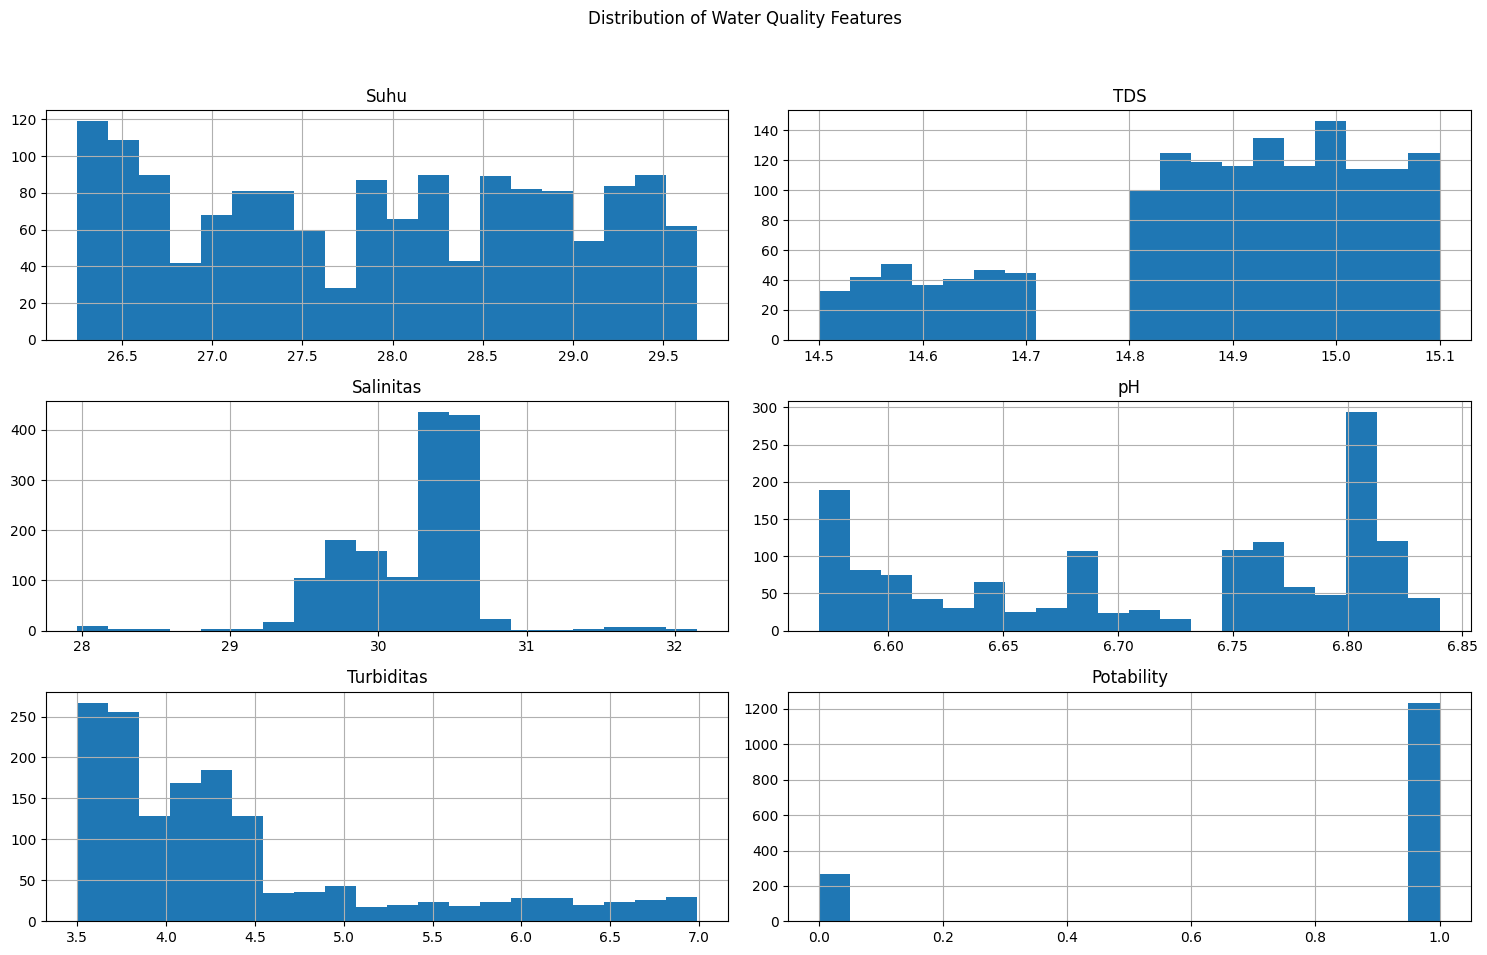

In [8]:
# Visualize the distribution of each feature
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Water Quality Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

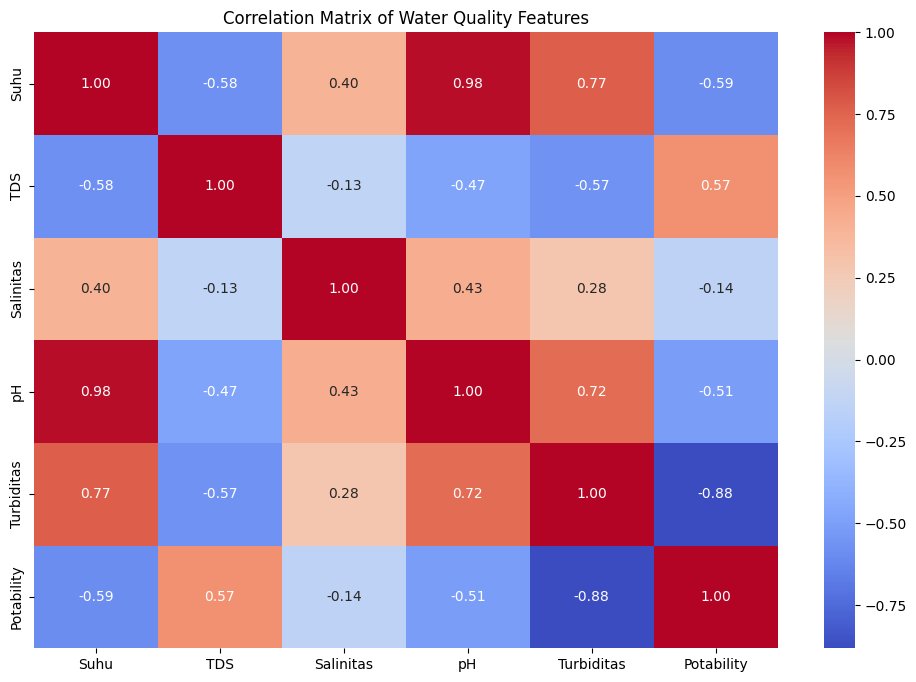

In [9]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Water Quality Features')
plt.show()

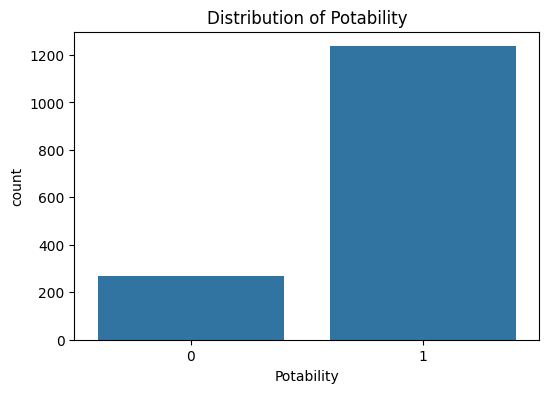

In [10]:
# Count plot for Potability
plt.figure(figsize=(6, 4))
sns.countplot(x='Potability', data=df)
plt.title('Distribution of Potability')
plt.show()

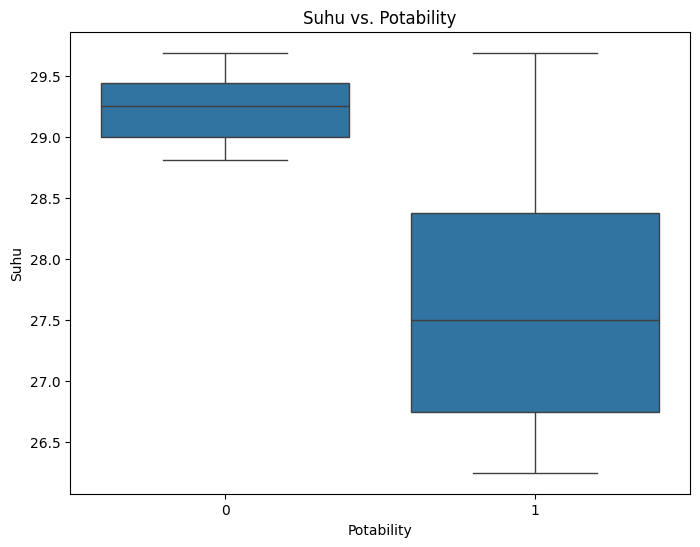

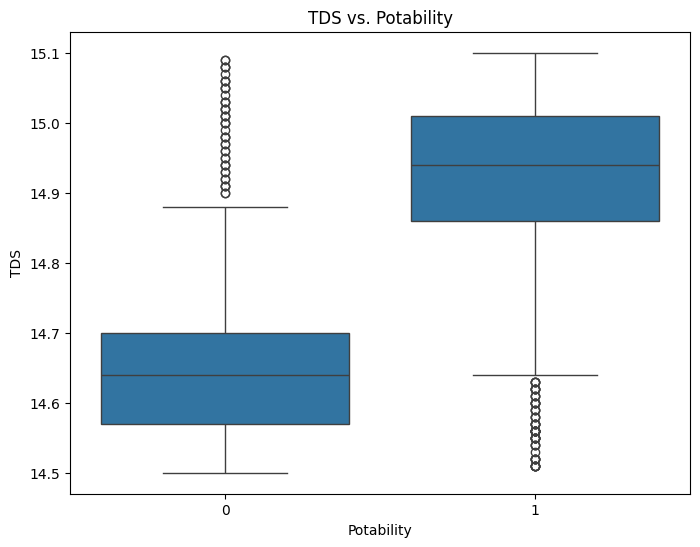

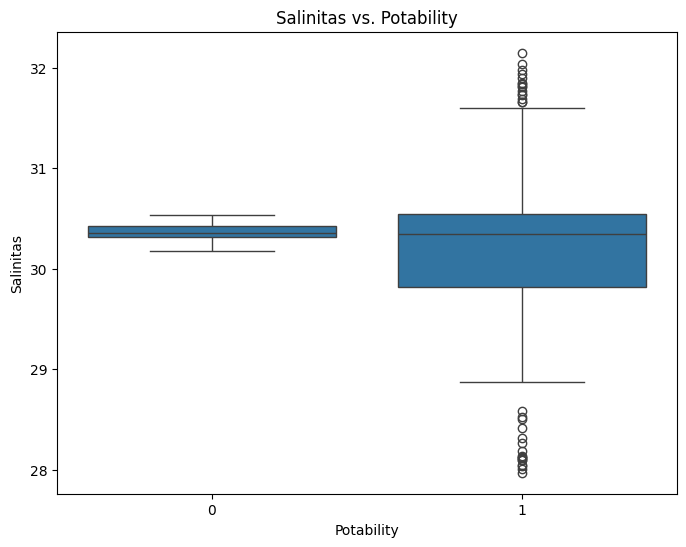

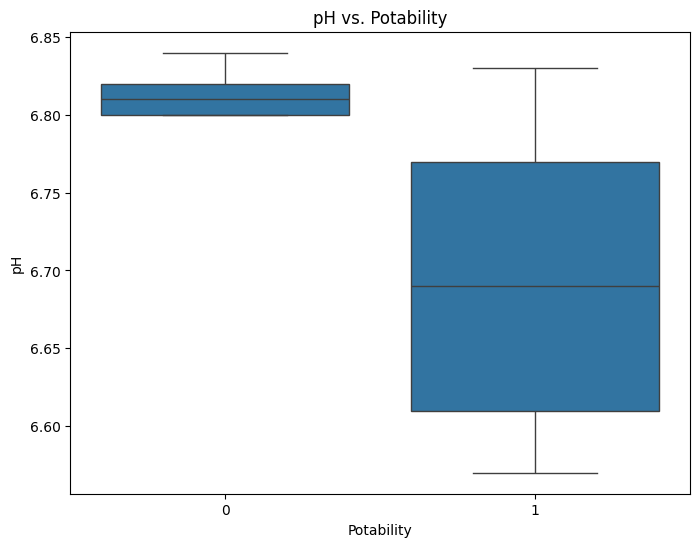

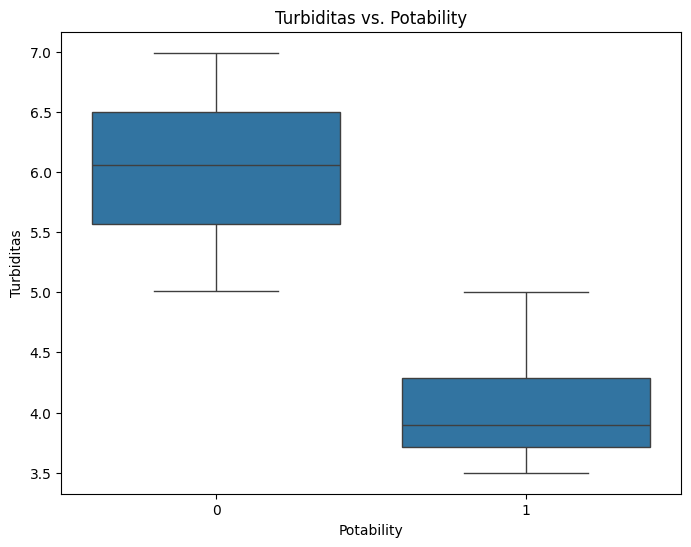

In [11]:
# Box plots for each feature vs. Potability
features = ['Suhu', 'TDS', 'Salinitas', 'pH', 'Turbiditas']
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Potability', y=feature, data=df)
    plt.title(f'{feature} vs. Potability')
    plt.show()

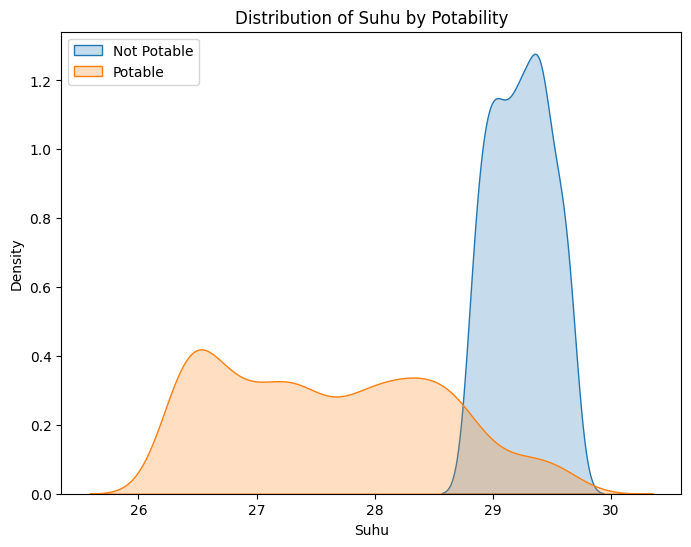

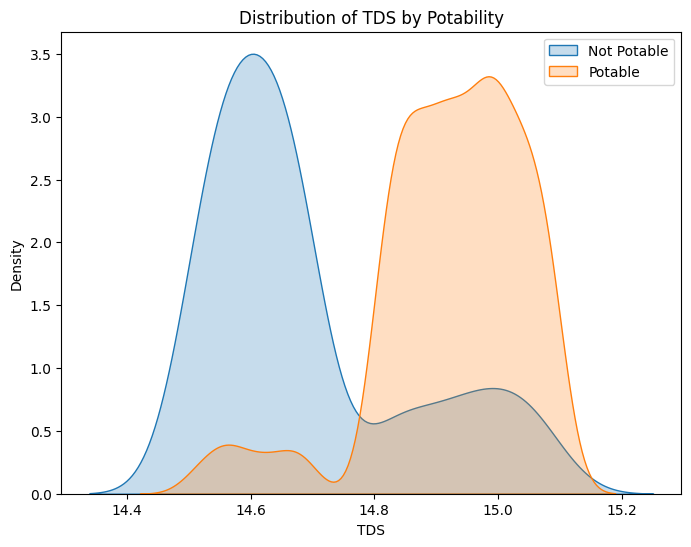

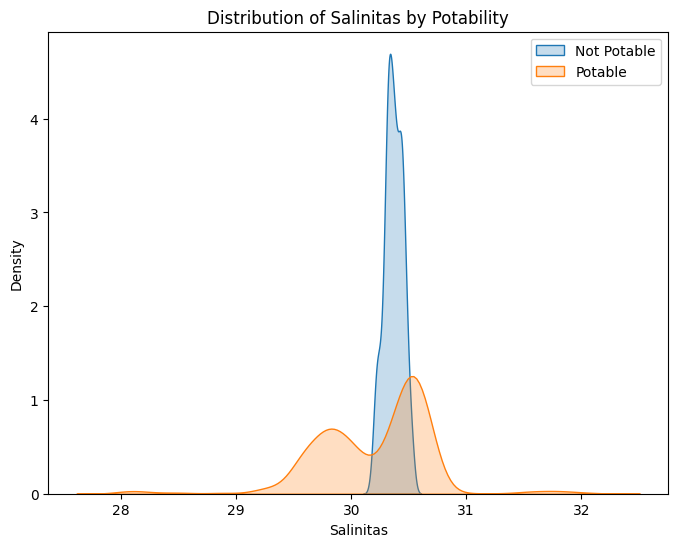

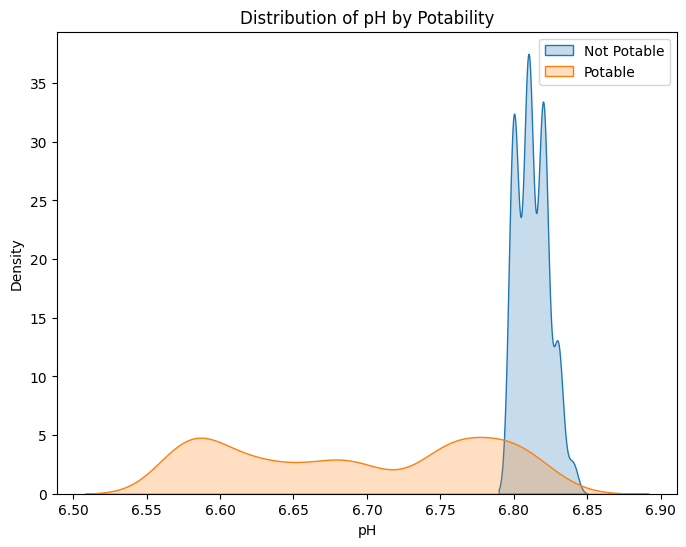

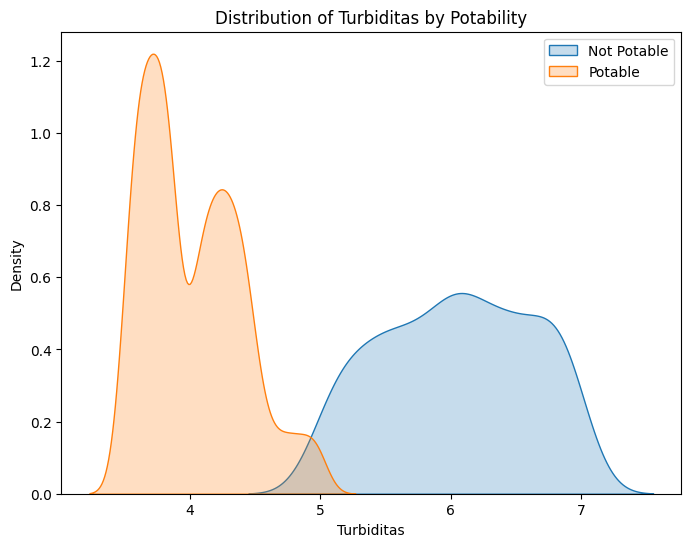

In [12]:
# KDE plots for each feature vs. Potability
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[df['Potability'] == 0][feature], label='Not Potable', fill=True)
    sns.kdeplot(df[df['Potability'] == 1][feature], label='Potable', fill=True)
    plt.title(f'Distribution of {feature} by Potability')
    plt.legend()
    plt.show()

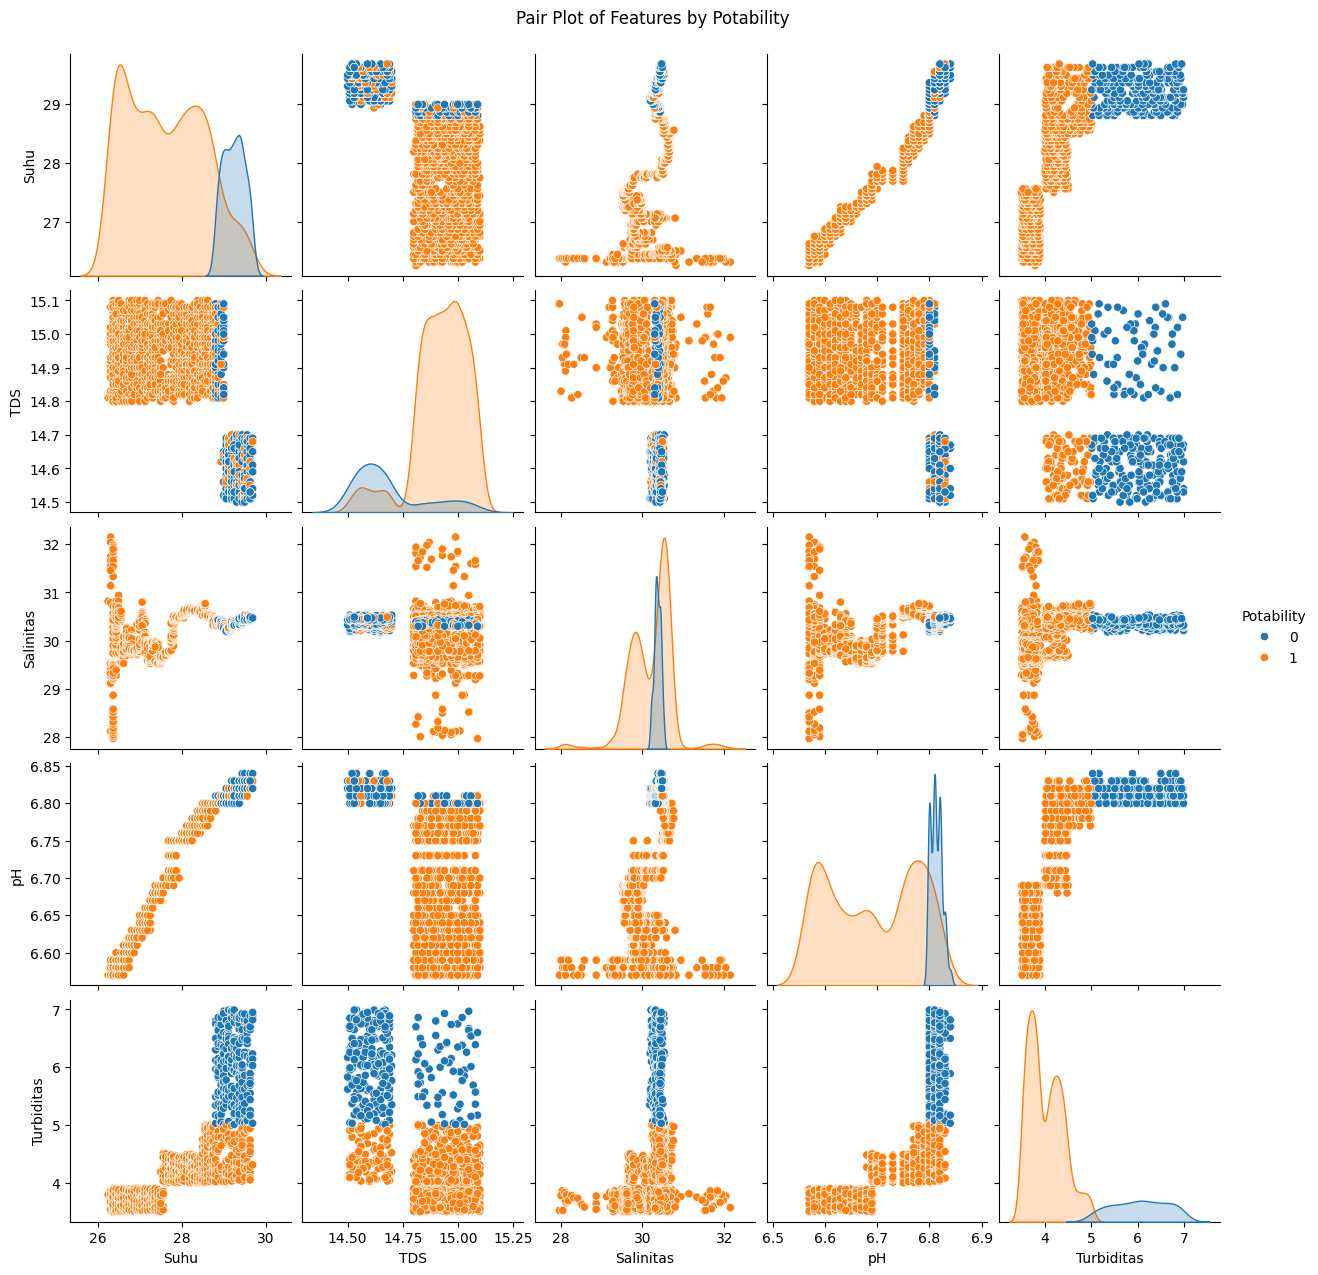

In [13]:
# Pair plot to visualize relationships between features
sns.pairplot(df, hue='Potability', diag_kind='kde')
plt.suptitle('Pair Plot of Features by Potability', y=1.02)
plt.show()

### Step 3: Find Best Data Split

--- Testing with split: 60/40 ---
Training set shape: (903, 5)
Test set shape: (603, 5)
Starting SVM Grid Search for rbf kernel...
SVM Grid Search complete.
Detailed Grid Search Results
   param_svc__kernel  param_svc__C  param_svc__gamma  mean_test_score  rank_test_score
13               rbf         100.0             0.100         0.994463                1
14               rbf         100.0             0.010         0.991154                2
8                rbf          10.0             1.000         0.991148                3
12               rbf         100.0             1.000         0.991142                4
9                rbf          10.0             0.100         0.990049                5
4                rbf           1.0             1.000         0.988944                6
0                rbf           0.1             1.000         0.987833                7
5                rbf           1.0             0.100         0.985611                8
15               rbf         10

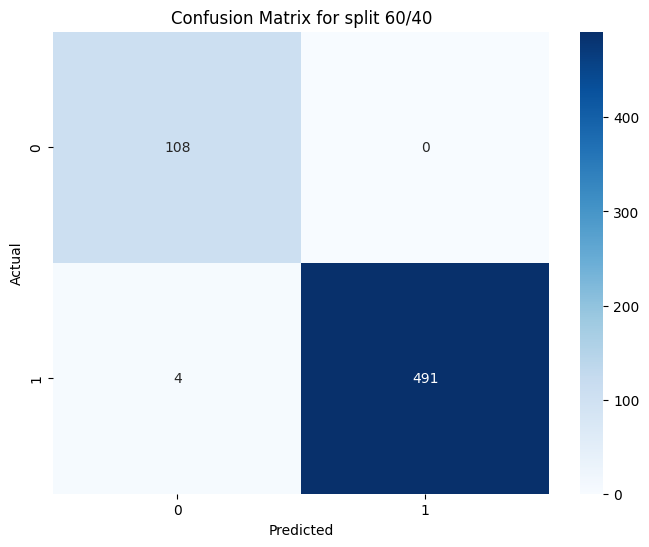

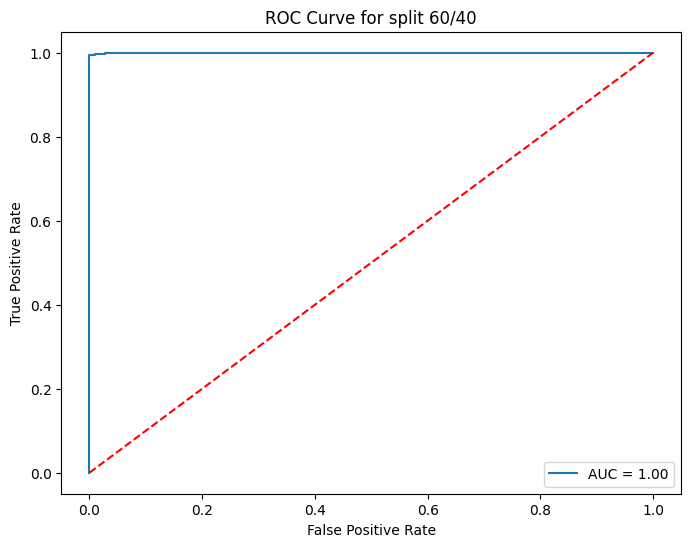

-----------------------------------------------------
--- Testing with split: 70/30 ---
Training set shape: (1054, 5)
Test set shape: (452, 5)
Starting SVM Grid Search for rbf kernel...
SVM Grid Search complete.
Detailed Grid Search Results
   param_svc__kernel  param_svc__C  param_svc__gamma  mean_test_score  rank_test_score
13               rbf         100.0             0.100         0.997156                1
8                rbf          10.0             1.000         0.996209                2
12               rbf         100.0             1.000         0.996209                2
9                rbf          10.0             0.100         0.991469                4
14               rbf         100.0             0.010         0.990521                5
4                rbf           1.0             1.000         0.989569                6
5                rbf           1.0             0.100         0.987673                7
0                rbf           0.1             1.000         0.

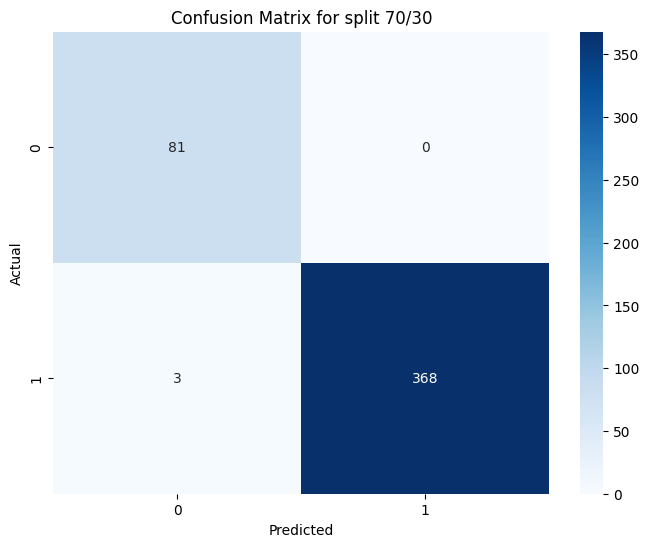

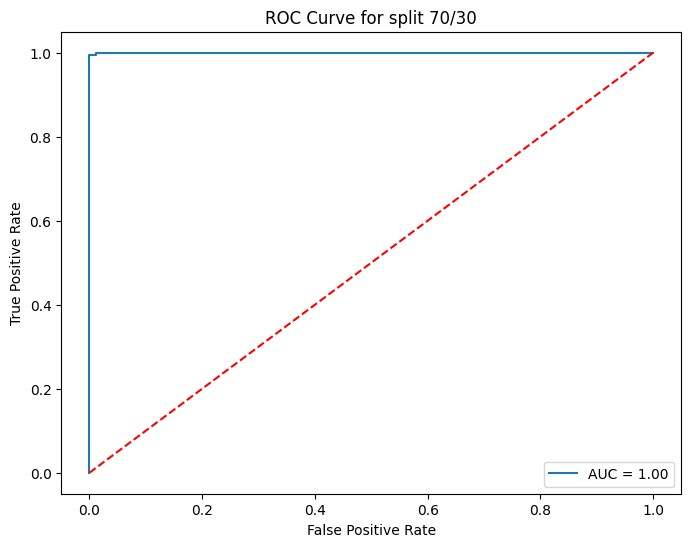

-----------------------------------------------------
--- Testing with split: 80/20 ---
Training set shape: (1204, 5)
Test set shape: (302, 5)
Starting SVM Grid Search for rbf kernel...
SVM Grid Search complete.
Detailed Grid Search Results
   param_svc__kernel  param_svc__C  param_svc__gamma  mean_test_score  rank_test_score
13               rbf         100.0             0.100         0.994180                1
8                rbf          10.0             1.000         0.993351                2
12               rbf         100.0             1.000         0.993347                3
9                rbf          10.0             0.100         0.992531                4
4                rbf           1.0             1.000         0.991701                5
14               rbf         100.0             0.010         0.991698                6
0                rbf           0.1             1.000         0.989205                7
10               rbf          10.0             0.010         0.

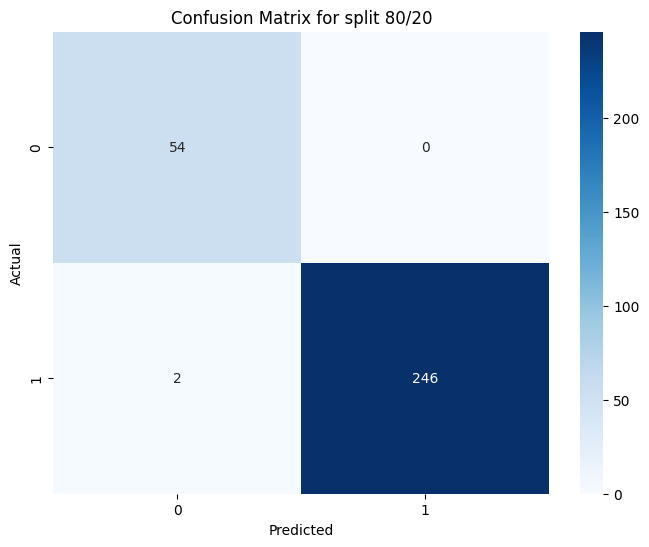

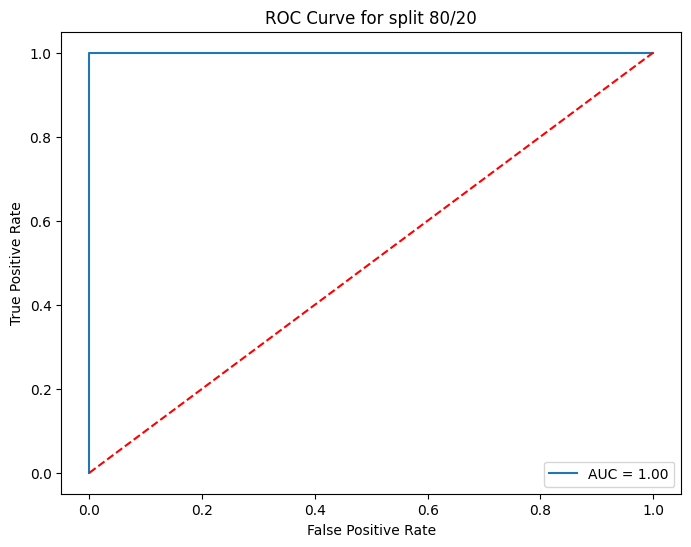

-----------------------------------------------------
--- Final Results ---
Split 60/40: Accuracy = 0.9934 with params {'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Split 70/30: Accuracy = 0.9934 with params {'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Split 80/20: Accuracy = 0.9934 with params {'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Performing Split: 80/20 with accuracy 0.9934


In [14]:
# Define the test sizes to experiment with
test_sizes = [0.4, 0.3, 0.2]
results = {}

# Define the SVM pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', random_state=42, probability=True))
])

# Define the hyperparameter grid for the RBF kernel
svm_param_grid = {
    'svc__kernel': ['rbf'],
    'svc__C': [0.1, 1, 10, 100 ],
    'svc__gamma': [1, 0.1, 0.01, 0.001,]
}

for test_size in test_sizes:
    print(f"--- Testing with split: {int((1-test_size)*100)}/{int(test_size*100)} ---")
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Perform Grid Search
    print("Starting SVM Grid Search for rbf kernel...")
    svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, n_jobs=-1, verbose=0)
    svm_grid_search.fit(X_train, y_train)
    print("SVM Grid Search complete.")

    # --- Display detailed results from GridSearchCV ---
    print("Detailed Grid Search Results")
    cv_results_df = pd.DataFrame(svm_grid_search.cv_results_)
    display_cols = [
        'param_svc__kernel', 'param_svc__C', 'param_svc__degree',
        'param_svc__gamma', 'mean_test_score', 'rank_test_score'
    ]
    existing_cols = [col for col in display_cols if col in cv_results_df.columns]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(cv_results_df[existing_cols].sort_values(by='rank_test_score'))
    print("------------------------------------")

    # Evaluate the best SVM model
    svm_y_pred = svm_grid_search.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_y_pred)
    results[f"{int((1-test_size)*100)}/{int(test_size*100)}"] = {"accuracy": svm_accuracy, "params": svm_grid_search.best_params_}
    
    print(f"Best SVM Parameters: {svm_grid_search.best_params_}")
    print(f"SVM Accuracy: {svm_accuracy}")
    print("SVM Classification Report:")
    print(classification_report(y_test, svm_y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for split {int((1-test_size)*100)}/{int(test_size*100)}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    y_pred_proba = svm_grid_search.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f'ROC Curve for split {int((1-test_size)*100)}/{int(test_size*100)}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    print("-----------------------------------------------------")

print("--- Final Results ---")
best_split = None
best_accuracy = 0
for split, result in results.items():
    print(f"Split {split}: Accuracy = {result["accuracy"]:.4f} with params {result["params"]}")
    if result["accuracy"] > best_accuracy:
        best_accuracy = result["accuracy"]
        best_split = split

print(f"Best Performing Split: {best_split} with accuracy {results[best_split]["accuracy"]:.4f}")

### Step 4: Train and Save the Final Model

In [15]:
# Create the final pipeline with the best parameters
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=100, gamma=0.1, kernel='rbf', class_weight='balanced', random_state=42, probability=True))
])

# Train the final model on the entire dataset
final_pipeline.fit(X, y)

# Save the trained model and the scaler
joblib.dump(final_pipeline, 'water_quality_model.pkl')

print("Final model trained and saved as water_quality_model.pkl")

Final model trained and saved as water_quality_model.pkl
